In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import glob, os
import torch
import numpy as np

import seaborn as sns
import config_matplotlib
config_matplotlib.config_matplotlib()


registered cmap: seaborn_cubehelix



In [2]:
summary_yaml = '/pscratch/sd/z/zhantao/inxs_steering_production/benchmarks/summary.yaml'

In [3]:
import yaml

with open(summary_yaml, 'r') as file:
    summary_dict = yaml.safe_load(file)


In [4]:
steps_of_interest = [25, 50]

In [5]:
mean_preds = []
true_values = []
sample_ids = []
maes = []


measured_angles = []
method = 'poisson_scaled'

for path in summary_dict['real'][method]:
    pt_flist = glob.glob(os.path.join(summary_dict['path'], path, '*.pt'))
    pt_indices = sorted([int(_.split('/')[-1].split('.')[0]) for _ in pt_flist])

    for _idx, _idx in enumerate(pt_indices):
        _pt = torch.load(os.path.join(summary_dict['path'], path, f'{_idx:02d}.pt'))
        # print(_pt.keys())
        _mean_preds = (_pt['positions'] * _pt['weights'].unsqueeze(-1)).sum(dim=-2) / _pt['weights'].sum(dim=-1).unsqueeze(-1)
        
        # _mean_preds = _pt['means']
        
        _maes = (_mean_preds - _pt['true_params'][None]).norm(dim=-1)
        
        mean_preds.append(_mean_preds.unsqueeze(0))
        maes.append(_maes[steps_of_interest].unsqueeze(0))
        sample_ids.append(_idx)
        true_values.append(_pt['true_params'])
        measured_angles.append(_pt['measured_angles'].unsqueeze(0))
        
maes = torch.vstack(maes).numpy()
mean_preds = torch.vstack(mean_preds).numpy()
sample_ids = torch.tensor(sample_ids).numpy()
true_values = torch.vstack(true_values).numpy()
measured_angles = torch.vstack(measured_angles).numpy()

Text(6.472222222222223, 0.5, 'Mean Absolute Error (MAE)')

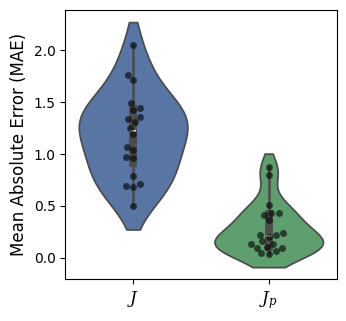

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(3.5, 3.5))
sns.violinplot(data=maes, ax=ax, cut=True)
sns.swarmplot(data=maes, ax=ax, color='black', alpha=0.6)
ax.set_xticks([0, 1])
ax.set_xticklabels(['$J$', '$J_{p}$'], fontsize=12)
ax.set_ylabel('Mean Absolute Error (MAE)')

Text(0, 0.5, '$J_{p}$')

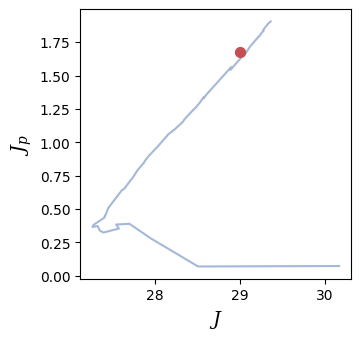

In [8]:
N_samp = mean_preds.shape[1]

N_samp_interp = 100

step = 20

markers = ['o', '^', 's', 'd']
fig, ax = plt.subplots(1,1,figsize=(3.5,3.5))

for _idx in range(1):
    ax.plot(mean_preds[_idx,:,0], mean_preds[_idx,:,1], color=f'C0', alpha=0.5, zorder=1)

ax.scatter(true_values[_idx,0], true_values[_idx,1], color=f'C2', zorder=10, s=50)
        
ax.set_xlabel('$J$', fontdict={'size': 14})
ax.set_ylabel('$J_{p}$', fontdict={'size': 14})
# ax.set_xlim(20, 40)
# ax.set_ylim(-5, 5)
# ax.legend(fontsize=12)

In [9]:
import sys
sys.path.append('../')

from inxss import SpecNeuralRepr
from inxss.steer_neutron import NeutronExperimentSteerer

In [10]:
import hydra
from hydra import initialize, compose
from hydra.core.global_hydra import GlobalHydra

GlobalHydra.instance().clear()

with initialize(config_path="../conf"):
    cfg = compose(config_name="config_gaussian")
    
model_path = cfg['paths']['model_path']
data = torch.load(cfg['paths']['data_path'])

device = 'cuda' if torch.cuda.is_available() else 'cpu'

/tmp/ipykernel_2331446/2448110181.py:7: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path="../conf"):


In [11]:
particle_filter_config = {
    "num_particles": 1000,
    "dim_particles": 2,
    "prior_configs": {'types': ['uniform', 'uniform'], 'args': [{'low': 20, 'high': 40}, {'low': -5, 'high': 5}]}
}


grid_info = {
    k: [v.min().item(), v.max().item(), len(v)] for k,v in data['grid'].items()
}

mask_config = {
    "raw_mask_path": cfg['paths']['raw_mask_path'],
    "memmap_mask_path": cfg['paths']['memmap_mask_path'],
    "grid_info": grid_info,
    "preload": False,
    "build_from_scratch_if_no_memmap": True,
    "global_mask": data['S']>0
}

experiment_config = {
    "q_grid": tuple([data['grid'][_grid] for _grid in ['h_grid', 'k_grid', 'l_grid']]),
    "w_grid": data['grid']['w_grid'],
    "S_grid": data['S'],
    "S_scale_factor": 1.
}

background_config = {
    "q_grid": tuple([data['grid'][_grid] for _grid in ['h_grid', 'k_grid', 'l_grid']]),
    "w_grid": data['grid']['w_grid'],
    "bkg_grid": data['background']
}

model = SpecNeuralRepr.load_from_checkpoint(model_path).to(device)

steer = NeutronExperimentSteerer(
    model, particle_filter_config=particle_filter_config,
    mask_config=mask_config, experiment_config=experiment_config, background_config=background_config,
    tqdm_pbar=False, lkhd_dict=cfg['likelihood'], device='cuda')

obtained memmap mask name as: mask_h_-2.0_2.0_121_k_-2.0_2.0_121_l_-10.0_4.5_30_w_20.0_200.0_91.npy


In [11]:
from inxss import linspace_2D_equidistant, plot_points, get_Sqw_func

_, kpt_indices = linspace_2D_equidistant([[0,0],[0.5,0],[0.5,0.5],[0,0]], 100, return_indices=True)
kpts = torch.from_numpy(linspace_2D_equidistant([[0,0],[0.5,0],[0.5,0.5],[0,0]], 100))
wpts = steer.experiment.w_grid
qw_coords = []
for _l in steer.experiment.l_grid:
    _qw_coords = torch.cat([
        kpts.unsqueeze(0).expand(wpts.shape[0], -1, -1),
        _l * torch.ones(wpts.shape[0], kpts.shape[0], 1),
        wpts.view(wpts.shape[0], -1).unsqueeze(1).expand(-1, kpts.shape[0], -1)
       ], dim=2)
    qw_coords.append(_qw_coords)
    
kpt_labels = ['$\Gamma$', 'X', 'M', '$\Gamma$']

In [12]:
S_exp = 0.
for _qw_coords in qw_coords:
    S_exp += steer.experiment.get_measurements_on_coords(_qw_coords)

In [29]:
_idx_demo_detail = 16
params_list = []
S_pred_list = []

steps_demo = [0, 3, 50]

for params in mean_preds[_idx_demo_detail,steps_demo,:]:
    params = torch.from_numpy(params).to(device)
    print(params)
    x = torch.zeros(wpts.shape[0], kpts.shape[0], 5)
    x[...,:3] = torch.cat([
        kpts.unsqueeze(0).expand(wpts.shape[0], -1, -1),
        wpts.view(wpts.shape[0], -1).unsqueeze(1).expand(-1, kpts.shape[0], -1)
    ], dim=2)
    x[...,3:] = params

    S_pred = model(x.to(model.device)).reshape(wpts.shape[0], kpts.shape[0]).detach().cpu().numpy()
    
    params_list.append(params)
    S_pred_list.append(S_pred)

tensor([2.9890e+01, 2.4094e-02], device='cuda:0', dtype=torch.float64)
tensor([27.7369,  0.0422], device='cuda:0', dtype=torch.float64)
tensor([29.1408,  1.8746], device='cuda:0', dtype=torch.float64)


In [30]:
cmap = sns.color_palette("rocket", as_cmap=True)

config_matplotlib.config_matplotlib()


registered cmap: seaborn_cubehelix



/global/u2/z/zhantao/Projects/inxs_steering/paper_preperation/config_matplotlib.py:44: UserWarning: Trying to register the cmap 'seaborn_cubehelix' which already exists.
  plt.register_cmap(cmap=cmap)


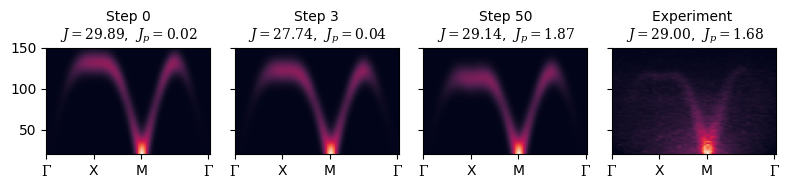

In [31]:

w_idx_upper = 65
aspect = 0.5
extent = [0, S_pred_list[0].shape[1], 
          steer.experiment.w_grid.min().item(), steer.experiment.w_grid[w_idx_upper].item()]

fig, ax = plt.subplots(1, 4, figsize=(8, 6))
for i in range(3):
    ax[i].imshow(S_pred_list[i][:w_idx_upper,:], origin='lower', cmap=cmap, extent=extent, aspect=aspect)
    ax[i].set_title(f'Step {steps_demo[i]}\n $J={params_list[i][0]:.2f}$,  $J_{{p}}={params_list[i][1]:.2f}$',
                    fontsize=10)
ax[3].imshow(S_exp[:w_idx_upper,:], origin='lower', cmap=cmap, extent=extent, aspect=aspect)
ax[3].set_title('Experiment \n $J=29.00$,  $J_{{p}}=1.68$',
                fontsize=10)

for i_ax, _ax in enumerate(ax):
    _ax.set_xticks(kpt_indices)
    _ax.set_xticklabels(kpt_labels)
    if i_ax > 0:
        _ax.set_yticklabels([])

# fig.suptitle(rf'$J={params[0]:.2f}, \ J_{{p}}={params[1]:.2f}$')
fig.tight_layout()
# fig.savefig(f"test_idx_{idx_plot}.svg", bbox_inches='tight')

In [32]:
np.where(mean_preds == mean_preds[:,:,0].min())

(array([16]), array([4]), array([0]))

In [40]:
maes.shape

(20, 2)

/tmp/ipykernel_718951/2587881052.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


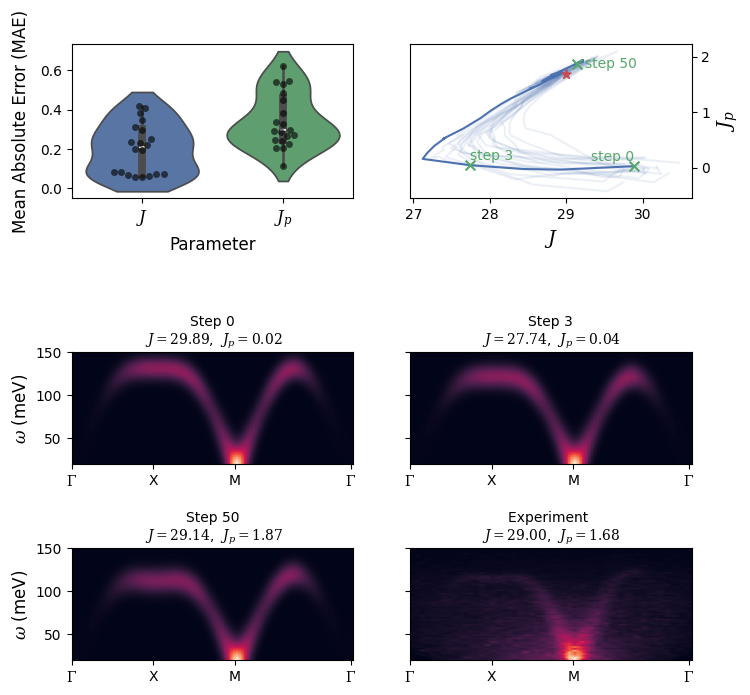

In [46]:
fig = plt.figure(figsize=(8,8))

gs = fig.add_gridspec(3, 2, height_ratios=[2, 1, 1], hspace=1.5)

ax1 = fig.add_subplot(gs[0, 0])
sns.violinplot(data=maes, ax=ax1, cut=True)
sns.swarmplot(data=maes, ax=ax1, color='black', alpha=0.6)
ax1.set_xticks([0, 1])
ax1.set_xticklabels(['$J$', '$J_{p}$'], fontsize=12)
ax1.set_ylabel('Mean Absolute Error (MAE)')
ax1.set_xlabel('Parameter')


ax2 = fig.add_subplot(gs[0, 1])
for _idx in range(mean_preds.shape[0]):
    if _idx == _idx_demo_detail:
        ax2.plot(mean_preds[_idx,:,0], mean_preds[_idx,:,1], color=f'C0', zorder=1)
    else:
        ax2.plot(mean_preds[_idx,:,0], mean_preds[_idx,:,1], color=f'C0', alpha=0.1, zorder=1)


ax2.scatter(true_values[_idx_demo_detail,0], true_values[_idx_demo_detail,1], marker='*', color=f'C2', zorder=10, s=50)     
ax2.scatter(mean_preds[_idx_demo_detail,steps_demo,0], mean_preds[_idx_demo_detail,steps_demo,1], marker='x', color='C1', zorder=10, s=50)
ax2.text(mean_preds[_idx_demo_detail,steps_demo[0],0], mean_preds[_idx_demo_detail,steps_demo[0],1]+0.05, 
         f'step {steps_demo[0]}', fontsize=10, ha='right', va='bottom', color='C1')
ax2.text(mean_preds[_idx_demo_detail,steps_demo[1],0], mean_preds[_idx_demo_detail,steps_demo[1],1]+0.05, 
         f'step {steps_demo[1]}', fontsize=10, ha='left', va='bottom', color='C1')
ax2.text(mean_preds[_idx_demo_detail,steps_demo[2],0]+0.1, mean_preds[_idx_demo_detail,steps_demo[2],1], 
         f'step {steps_demo[2]}', fontsize=10, ha='left', va='center', color='C1')
ax2.set_xlabel('$J$', fontdict={'size': 14})
ax2.set_ylabel('$J_{p}$', fontdict={'size': 14})
ax2.yaxis.tick_right()  # Move yticks to the right
ax2.yaxis.set_label_position("right")  # Move ylabels to the right

cmap = sns.color_palette("rocket", as_cmap=True)
sub_gs = gs[1:,:].subgridspec(2, 2, hspace=0.75)

aspect = 'auto'
axes_to_align1 = []
axes_to_align2 = []
for i in range(3):
    _ax = fig.add_subplot(sub_gs[i//2, i%2])
    _ax.imshow(S_pred_list[i][:w_idx_upper,:], origin='lower', cmap=cmap, extent=extent, aspect=aspect)
    _ax.set_title(f'Step {steps_demo[i]}\n $J={params_list[i][0]:.2f}$,  $J_{{p}}={params_list[i][1]:.2f}$',
                    fontsize=10)
    _ax.set_xticks(kpt_indices)
    _ax.set_xticklabels(kpt_labels)
    if i == 1 or i == 3:
        _ax.set_yticklabels([])
        axes_to_align2.append(_ax)
    else:
        _ax.set_ylabel('$\omega$ (meV)')
        axes_to_align1.append(_ax)

ax = fig.add_subplot(sub_gs[1, 1])
ax.imshow(S_exp[:w_idx_upper,:], origin='lower', cmap=cmap, extent=extent, aspect=aspect)
ax.set_title('Experiment \n $J=29.00$,  $J_{{p}}=1.68$',
                fontsize=10)
ax.set_yticklabels([])
ax.set_xticks(kpt_indices)
ax.set_xticklabels(kpt_labels)

fig.align_ylabels([ax1]+axes_to_align1)

fig.tight_layout()
fig.savefig(f'figures/exp_benchmark_summary_{method}.pdf', bbox_inches='tight')


/tmp/ipykernel_718951/2063997458.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


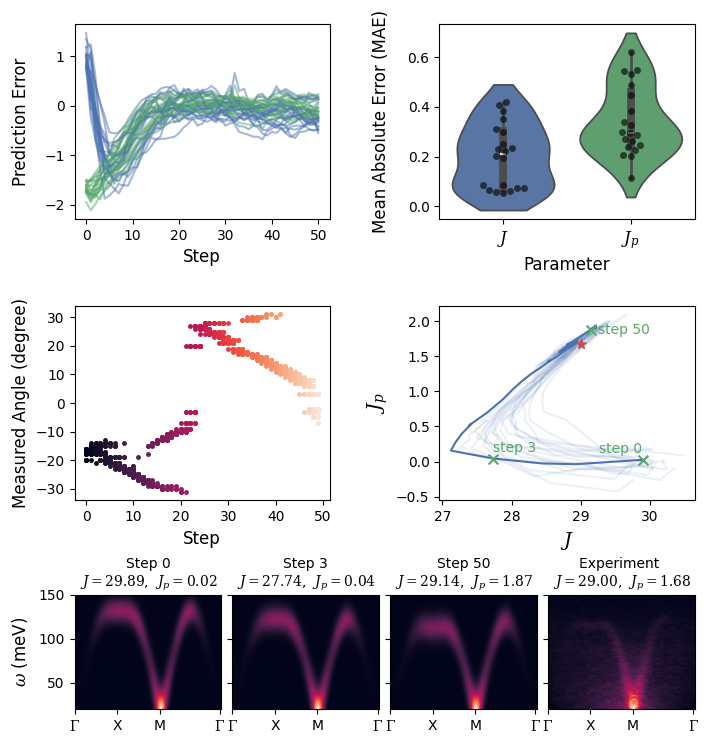

In [146]:
fig = plt.figure(figsize=(8,9))

gs = fig.add_gridspec(3, 4, height_ratios=[3,3,2], wspace=1.5, hspace=0.5)


ax_mae_hist = fig.add_subplot(gs[0, 2:])
ax_traj = fig.add_subplot(gs[1, 2:])
ax_ang = fig.add_subplot(gs[1, :2])
ax_mae_step = fig.add_subplot(gs[0, :2])

sns.violinplot(data=maes, ax=ax_mae_hist, cut=True)
sns.swarmplot(data=maes, ax=ax_mae_hist, color='black', alpha=0.6)
ax_mae_hist.set_xticks([0, 1])
ax_mae_hist.set_xticklabels(['$J$', '$J_{p}$'], fontsize=12)
ax_mae_hist.set_ylabel('Mean Absolute Error (MAE)')
ax_mae_hist.set_xlabel('Parameter')


for _idx in range(mean_preds.shape[0]):
    if _idx == _idx_demo_detail:
        ax_traj.plot(mean_preds[_idx,:,0], mean_preds[_idx,:,1], color=f'C0', zorder=1)
    else:
        ax_traj.plot(mean_preds[_idx,:,0], mean_preds[_idx,:,1], color=f'C0', alpha=0.1, zorder=1)


ax_traj.scatter(true_values[_idx_demo_detail,0], true_values[_idx_demo_detail,1], marker='*', color=f'C2', zorder=10, s=50)     
ax_traj.scatter(mean_preds[_idx_demo_detail,steps_demo,0], mean_preds[_idx_demo_detail,steps_demo,1], marker='x', color='C1', zorder=10, s=50)
ax_traj.text(mean_preds[_idx_demo_detail,steps_demo[0],0], mean_preds[_idx_demo_detail,steps_demo[0],1]+0.05, 
         f'step {steps_demo[0]}', fontsize=10, ha='right', va='bottom', color='C1')
ax_traj.text(mean_preds[_idx_demo_detail,steps_demo[1],0], mean_preds[_idx_demo_detail,steps_demo[1],1]+0.05, 
         f'step {steps_demo[1]}', fontsize=10, ha='left', va='bottom', color='C1')
ax_traj.text(mean_preds[_idx_demo_detail,steps_demo[2],0]+0.1, mean_preds[_idx_demo_detail,steps_demo[2],1], 
         f'step {steps_demo[2]}', fontsize=10, ha='left', va='center', color='C1')
ax_traj.set_xlabel('$J$', fontdict={'size': 14})
ax_traj.set_ylabel('$J_{p}$', fontdict={'size': 14})
# ax_traj.yaxis.tick_right()  # Move yticks to the right
# ax_traj.yaxis.set_label_position("right")  # Move ylabels to the right

for i in range(measured_angles.shape[1]):
    ax_ang.plot(i * np.ones_like(measured_angles[:,i]), measured_angles[:,i], 'o', color=cmap(i/50), markersize=2.5);
ax_ang.set_xlabel('Step')
ax_ang.set_ylabel('Measured Angle (degree)')


mae_hist = (mean_preds - true_values[:,None,:])
for i in range(mae_hist.shape[0]):
    ax_mae_step.plot(np.arange(mae_hist.shape[1]), mae_hist[i,:,0], alpha=0.5, color='C0')
    ax_mae_step.plot(np.arange(mae_hist.shape[1]), mae_hist[i,:,1], alpha=0.5, color='C1')
ax_mae_step.set_xlabel('Step')
ax_mae_step.set_ylabel('Prediction Error')

cmap = sns.color_palette("rocket", as_cmap=True)
sub_gs = gs[-1,:].subgridspec(1, 4, wspace=0.075)

aspect = .6
axes_to_align1 = []
for i in range(3):
    _ax = fig.add_subplot(sub_gs[0, i])
    _ax.imshow(S_pred_list[i][:w_idx_upper,:], origin='lower', cmap=cmap, extent=extent, aspect=aspect)
    _ax.set_title(f'Step {steps_demo[i]}\n $J={params_list[i][0]:.2f}$,  $J_{{p}}={params_list[i][1]:.2f}$',
                    fontsize=10)
    _ax.set_xticks(kpt_indices)
    _ax.set_xticklabels(kpt_labels)
    if i >0:
        _ax.set_yticklabels([])
        axes_to_align2.append(_ax)
    else:
        _ax.set_ylabel('$\omega$ (meV)')
        axes_to_align1.append(_ax)

ax = fig.add_subplot(sub_gs[-1, -1])
ax.imshow(S_exp[:w_idx_upper,:], origin='lower', cmap=cmap, extent=extent, aspect=aspect)
ax.set_title('Experiment \n $J=29.00$,  $J_{{p}}=1.68$',
                fontsize=10)
ax.set_yticklabels([])
ax.set_xticks(kpt_indices)
ax.set_xticklabels(kpt_labels)

fig.align_ylabels([ax_mae_step, ax_ang, ] + axes_to_align1)
fig.align_ylabels([ax_mae_hist, ax_traj])

fig.tight_layout()
fig.savefig('figures/exp_benchmark_summary.pdf', bbox_inches='tight')


Text(0, 0.5, 'Measured Angle (degree)')

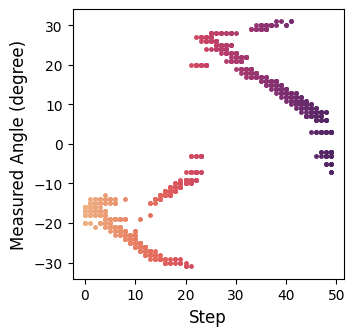

In [79]:
from matplotlib.colors import ListedColormap
measured_angles[measured_angles > 180] -= 360

cmap = sns.color_palette("flare", as_cmap=True)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3.5))
for i in range(measured_angles.shape[1]):
    ax.plot(i * np.ones_like(measured_angles[:,i]), measured_angles[:,i], 'o', color=cmap(i/50), markersize=2.5);
ax.set_xlabel('Step')
ax.set_ylabel('Measured Angle (degree)')

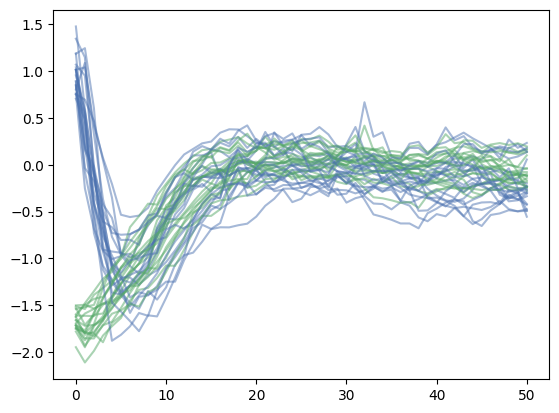

In [93]:
mae_hist = (mean_preds - true_values[:,None,:])

for i in range(mae_hist.shape[0]):
    plt.plot(np.arange(mae_hist.shape[1]), mae_hist[i,:,0], alpha=0.5, color='C0')
    plt.plot(np.arange(mae_hist.shape[1]), mae_hist[i,:,1], alpha=0.5, color='C1')
    